In [469]:
import re 
import string
import timestring
from sklearn.linear_model import LinearRegression, LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, KFold
import glob, os
import numpy as np
from sklearn import svm
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import pickle
from datetime import datetime


In [470]:
DIR = '/data/2/protest'

In [471]:
class Tokenizer:
    def __init__(self, collapse_mentions=False, collapse_digits=True):
        self.collapse_mentions = collapse_mentions
        self.collapse_digits = collapse_digits
        self.stopwords = stopwords
        
    def tokenize(self, text):
        punc_re = '[' + '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\_\\{\\|\\}' + ']'
        text = text.lower()
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
        if self.collapse_mentions:
            text = re.sub('@\S+', 'MENTION', text)
        else:
            text = re.sub('@\S+', 'MENTION_\1', text)
        text = re.sub('http\S+', 'THIS_IS_A_URL', text)
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
        if self.collapse_digits: # Numbers help!
            text = re.sub(r'[0-9]', '9', text) 
        toks = []
        for tok in text.split():
            tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
            tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
            for subtok in tok.split():
                if re.search('\w', subtok):
                    toks.append(subtok)
        return toks

In [472]:
def print_top_terms(clf, vec, n=100):
    feats = np.array(vec.get_feature_names())
    print('\n'.join(feats[np.argsort(clf.coef_[0])[::-1][:n]]))

In [473]:
def read_stopwords(path):
    return [s.strip().lower() for s in open(path)]

In [474]:
#parse date 
def parse_date(datestring):
    from datetime import datetime

    """ Input, e.g., Mon Aug 24 19:41:14 +0000 2015
    Output, e.g., 24 """
    #Sat May 16 16:30:12 +0000 2015
    #print datestring
    parts = datestring.split()
    var = datetime.strptime(parts[1]+' ' +parts[2]+' '+ parts[5],'%b %d %Y')
    return var

In [475]:
def iterate_instances_changed(files, keywords, window_sz, gap_sz,files_train):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username, percentage of neightbors who used hashtag)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    Also we find neighbors (define as those with symetric mentions) who have also used one of the keywords 
    during positive or negative window 
    """
    DIR = '/home/elaine/Protest/protest/Brazil project/'
    DIR2='/data/2/protest/mentions/'
    dic = defaultdict(tuple)
    pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
    data1 = pickle.load(pkl_file)

    for _, _, f in os.walk(DIR2): f
        
    for _, _, arquivos in os.walk(files): arquivos
        
    for fname in files_train:#glob.glob(path + '/*.txt'):
        
        user = filename2user(arquivos[fname])
        #print('this is', user)
        lines = []
        countneg=0
        countpos=0
        #print('treino',user)
        for i, line in enumerate(open(files+arquivos[fname])):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', arquivos[fname], 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                pos_start = max(0, i - window_sz)
                #print('positive window starts in',pos_start)
                pos_end = i+1
                #print('positive window finishes in',pos_end)

                #print('lineslen: ',len(lines))
                date1_pos = lines[pos_start][1]
                #print('ksdjsk',lines[pos_start][1])
                #print(pos_end)
                date2_pos = lines[pos_end-2][1]

                neg_start = max(0, i - gap_sz - (2 * window_sz))
                #print('negative window starts in',neg_start)
                neg_end = i - gap_sz - window_sz
                #print('nagative window finishes in',neg_end)
                date1_neg = lines[neg_start][1]
                date2_neg = lines[neg_end][1]

                if data1.has_node(user) == True: #if that file is in the graph
                    #print(user, 'is in the graph!')
                    neighbors = data1.neighbors(user) #get all neighbors of the user
                    #print(user, 's neighbors are: ', neighbors)
                    for n in neighbors:
                        if n +'.txt' in f:#if that file is in the directory
                            #print('vizinho: ', n)
                            neighbor = open(DIR2 + n +'.txt','r')
                            nlines = neighbor.readlines()
                            for t in reversed(nlines):
                                tweet_neighbor = json.loads(t) 
                                #print(tweet_neighbor['created_at'])
                                #print(parse_date(tweet_neighbor['created_at']) ,'>', parse_date(date1_pos) )
                                if matches_keywords(tweet_neighbor['text'],keywords):
                                    if parse_date(tweet_neighbor['created_at']) > parse_date(date1_pos) and parse_date(tweet_neighbor['created_at']) < parse_date(date2_pos):
                                        #print(n, 'posted keyword in', parse_date(tweet_neighbor['created_at']))
                                        #print('entrou!!')
                                        countpos = countpos+1
                                        break
                            for t in reversed(nlines):
                                tweet_neighbor = json.loads(t) 
                                if matches_keywords(tweet_neighbor['text'],keywords):
                                    if parse_date(tweet_neighbor['created_at']) < parse_date(date2_neg) and parse_date(tweet_neighbor['created_at']) > parse_date(date2_neg):
                                        #print(n, 'posted negkeyword in', parse_date(tweet_neighbor['created_at']))
                                        #print('1entrou!!')
                                        countneg = countneg+1
                                        break
                            dic[user]=((float(countpos)/float(len(neighbors))),float(countneg)/float(len(neighbors)))
                #print('diccc',dic)
                # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
                #print('testeee',lines[0][pos_start:pos_end])
                testepos = " ".join(l[0] for l in lines[pos_start:pos_end])
                testeneg = " ".join(l[0] for l in lines[neg_start:neg_end])
                
                yield (testepos, 1, user, float(countpos)/float(len(neighbors)))
                yield (testeneg, 0, user,float(countneg)/float(len(neighbors)))
                countneg=0
                countpos=0
                break
            lines.append((js['text'],js['created_at']))
    #print(dic)

In [476]:
from sklearn.feature_extraction import text

toker = Tokenizer(collapse_digits=False, collapse_mentions=True)

stopwords = set(read_stopwords(DIR + '/stopwords.txt'))    
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)

vectorizer = TfidfVectorizer(binary=False, decode_error='ignore',ngram_range=(1,2),
                                 max_df=1.0, min_df=2, use_idf=True,
                                 tokenizer=toker.tokenize,
                                 norm='l2', stop_words=set(my_stop_words))

In [477]:
def read_keywords(path):
    return [s.strip().lower() for s in open(path)]
    
keywords = read_keywords(DIR + '/keywords.txt')
keywords

['foradilma', 'fora dilma', 'forapt', 'fora pt', 'vemprarua', 'vem pra rua']

In [478]:
def plot_probs(dictv,name):
    %pylab inline
    fig = plt.figure(figsize=(40,10))
 
    for k, v in dictv.items():
        i=1
        y=[]
        x=[]
        t = 1/len(dictv[k])
        for g in dictv[k]:
            y.append(g)
            x.append(i*t)
            i = i+1
        plt.xlabel('% of total tweets')
        plt.ylabel('Probability')
        plt.plot(x,y)
    plt.savefig(name)

In [480]:
def iterate_Testing_instances(path,files_test):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """ 
    for _, _, arquivos in os.walk(path): arquivos
        
    for fname in files_test:#glob.glob(path + '/*.txt'):
        
        user = filename2user(arquivos[fname])
        
        lines = []
        var=None
        #weetlist=[]
        count=0
        for i, line in enumerate(open(path+arquivos[fname])):
            js = json.loads(line)
            #ines.append(js['text'])
            # exclude people who use keyword within first `window` of tweets.
            """if i <= negative_window and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > negative_window and matches_keywords(js['text'], keywords):
                #print(user)
                var=''
                for l in lines[-100:][::-1]:
                    var = var + l
                    yield(var,user)
                var=None
                break"""
            if matches_keywords(js['text'], keywords):
                #print('test',user)
                v=''
                count=0
                #print('len of lines', len(lines))
                for k,l in enumerate(lines[:][::-1]):
                    #print(l)
                    v=v+l
                    count=count+1
                    if count==20:
                        #print('count',count)
                        count=0
                        yield(v,user)
                        v=None
                        v=""
                    elif(count<20 and k == (len(lines)-1)):  #PS.: if first tweet of user is with keyword this user is not counted!
                        #print('count',count)
                        count=0
                        yield(v,user)
                        v=None
                        v=""
                break
            lines.append(js['text'])
            
#y = []
#users = []
#negative_window = 10
# The loop below iterates over each instance and vectorizes the text.
# Simulataneously, we append to the y (labels) and users lists.
# We do this to avoid having to store all the text in memory at once and to 
# only require one loop through the files.
"""files_test=[]
for _, _, arquivos in os.walk(DIR + '/Timeline/'): arquivos#list of all files in the directory
for f in arquivos:
    if f not in set(files_train):
        files_test.append(f)

print(len(arquivos))
print(len(set(files_test)))
print(len(files_train))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window, files_test)
X_ = vectorizer.transform(x[0] for x in iterator1 if not users.append(x[1]))
print('read %d instances into X matrix with shape %s' % (len(users), str(X_.shape)))
#print('label distribution=', Counter(y))
#y = np.array(y)
#users = np.array(users)
#print(type(y))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window,files_test)
iter1=list(iterator1)"""

"files_test=[]\nfor _, _, arquivos in os.walk(DIR + '/Timeline/'): arquivos#list of all files in the directory\nfor f in arquivos:\n    if f not in set(files_train):\n        files_test.append(f)\n\nprint(len(arquivos))\nprint(len(set(files_test)))\nprint(len(files_train))\niterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window, files_test)\nX_ = vectorizer.transform(x[0] for x in iterator1 if not users.append(x[1]))\nprint('read %d instances into X matrix with shape %s' % (len(users), str(X_.shape)))\n#print('label distribution=', Counter(y))\n#y = np.array(y)\n#users = np.array(users)\n#print(type(y))\niterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window,files_test)\niter1=list(iterator1)"

288 33
read 362 instances into X training matrix with shape (356, 6729)
label distribution= Counter({0: 181, 1: 181})
read 1068 instances into X_ testing matrix with shape (1068, 6850)
1068
users1 1068
dictv 32
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
newdcit 32
289 32
read 356 instances into X training matrix with shape (356, 6729)
label distribution= Counter({0: 178, 1: 178})
read 1843 instances into X_ testing matrix with shape (1843, 6769)
1843
users1 1843
dictv 63
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
newdcit 31
289 32
read 360 instances into X training matrix with shape (356, 6729)
label distribution= Counter({0: 180, 1: 180})
read 1374 instances into X_ testing matrix with shape (1374, 6864)
1374
users1 1374
dictv 95
Populating the interactive namespace from numpy and matplotlib
Populating the interactive nam

`%matplotlib` prevents importing * from pylab and numpy


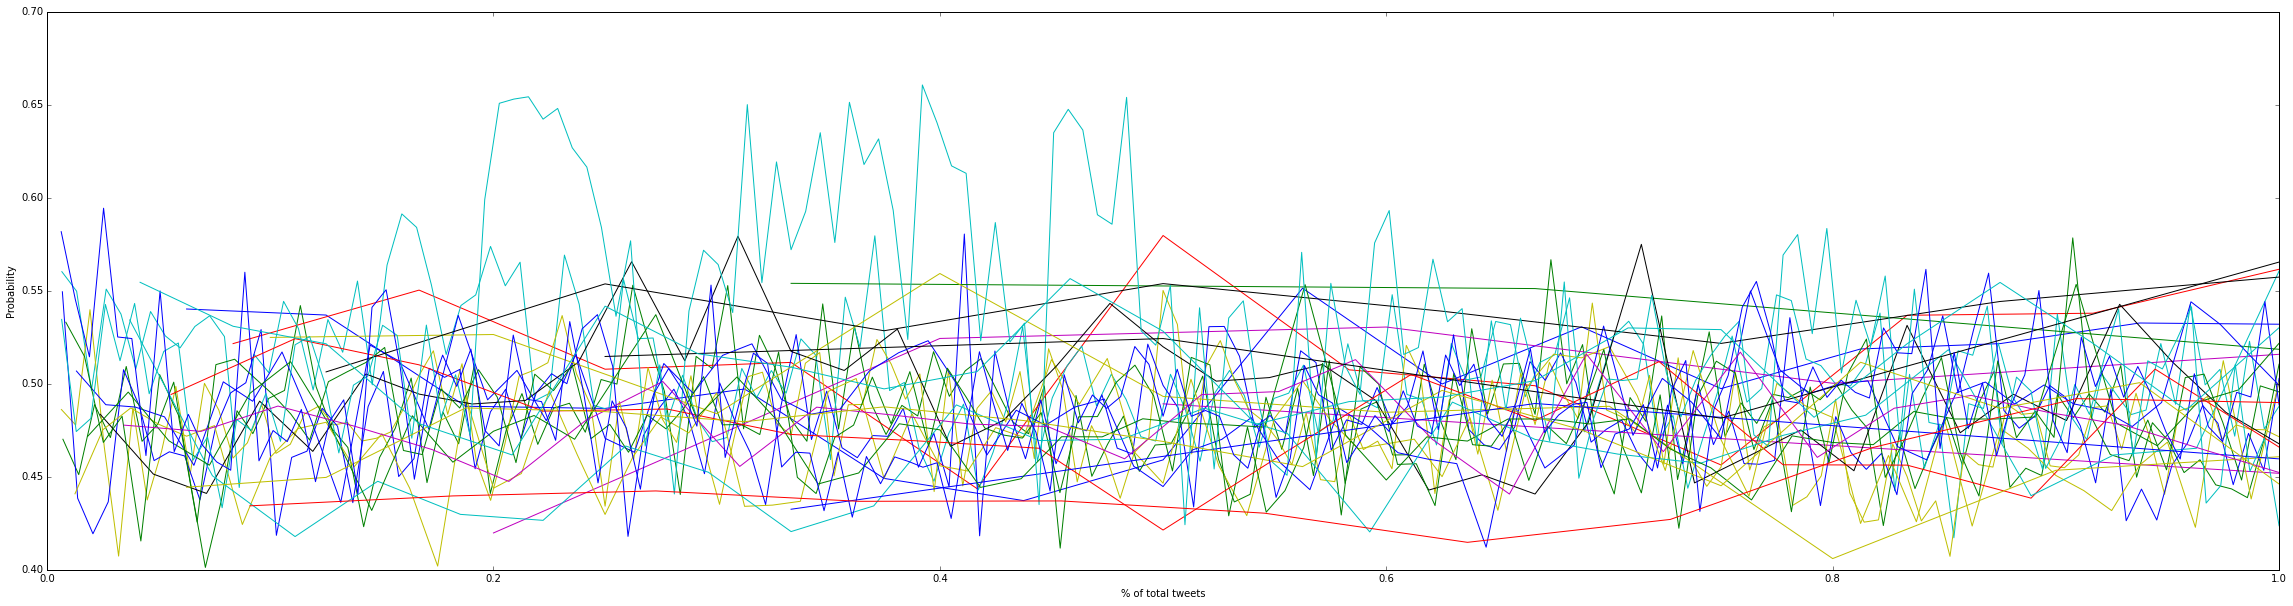

In [481]:
# cross validation process

dictv = defaultdict(list)
newdictv = defaultdict(list)

model_mod = LogisticRegression(penalty='l2', C=1)

treino_y=[]
plots=[]
t=0
allusers=[]

for _, _, arquivos in os.walk(DIR + '/Timeline/'): arquivos

cv = KFold(len(arquivos), 10,shuffle=False)
preds=None
for train_ind, test_ind in cv: 
    print(len(train_ind), len(test_ind))
    #files, keywords, window_sz, gap_sz,files_train
    iterator = iterate_instances_changed(DIR + '/Timeline/', keywords, 20,100, train_ind)
    treino_y=[]
    users=[]
    treino_X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not treino_y.append(x[1]))
    print('read %d instances into X training matrix with shape %s' % (len(users), str(X.shape)))
    print('label distribution=', Counter(treino_y))

    iterator1 = iterate_Testing_instances(DIR + '/Timeline/', test_ind)
    users1=[]
    X_ = vectorizer.transform(x[0] for x in iterator1 if not users1.append(x[1]))
    print('read %d instances into X_ testing matrix with shape %s' % (len(users1), str(X_.shape)))

    treino_y = np.array(treino_y)
    
    model_mod.fit(treino_X,treino_y)   
    preds = model_mod.predict_proba(X_)
    print(len(preds))
    
    #iterator1 = iterate_Testing_instances(DIR + '/Timeline/', test_ind)
    #iter1=list(iterator1)
    #print(users1)
    for o in zip(users1, preds):
        #print(o[1][1])
        allusers.append(o[0])
        dictv[(o[0])].append(o[1][1])
        newdictv[(o[0])].append(o[1][1])

    t=t+1
    print('users1',len(users1))

    print('dictv',len(dictv))
    name = ['a','b','c','d','e','f','g','h','i','j']#names for each plot
    name_sep = ['aa','bb','cc','dd','ee','ff','gg','hh','ii','jj']
    plot_probs(dictv,name[t-1])
    plot_probs(newdictv,name_sep[t-1])
    print('newdcit', len(newdictv))
    newdictv = defaultdict(list)

In [125]:
all_files = list(glob.glob(DIR + '/Timeline/*.txt'))
window_sz=20  
gap_sz=100
users = []
y=[]

iterator = iterate_instances(all_files, keywords, window_sz, gap_sz)
X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
y = np.array(y)

In [126]:
#y = np.array(y)
model_mod = LogisticRegression(penalty='l2', C=1)
model_mod.fit(X, y)


# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

# 10 Cross-validation accuracy
cv = KFold(len(y), 10, shuffle=False)  # Don't shuffle b/c we don't want a user in both training and testing set.
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind],y[train_ind])   
    accuracies.append(accuracy_score(y[test_ind], model_mod.predict(X[test_ind])))
    
print('Average 10-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies)))

predicted = model_mod.predict(X)
print('accuracy on training data=%.4f' % accuracy(y, predicted))

Average 10-fold cross validation accuracy=0.5784 (std=0.05)
accuracy on training data=0.9382


In [385]:
import os, io, json, codecs

def matches_keywords(text, keywords):
    """ Return true if any keyword is a substring of this text, ignoring case. """
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return True
    return False

def filename2user(fname):
    """Convert filename like this
      /data/2/protest/Timeline/MandinhaSimone.txt.txt
    into a username like
      MandinhaSimone
    """
    return re.sub(r'^([^\.]+)\..+', r'\1', os.path.basename(fname))

def iterate_instances(files, keywords, window_sz, gap_sz,files_train):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """
    for _, _, arquivos in os.walk(path): arquivos
        
    for fname in files_train:#glob.glob(path + '/*.txt'):
        
        user = filename2user(arquivos[fname])
        lines = []
        #print('treino',user)
        for i, line in enumerate(open(path+arquivos[fname])):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                pos_start = max(0, i - window_sz)
                pos_end = i+1
                neg_start = max(0, i - gap_sz - (2 * window_sz))
                neg_end = i - gap_sz - window_sz
                # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
                yield (' '.join(lines[pos_start:pos_end]), 1, user)
                yield (' '.join(lines[neg_start:neg_end]), 0, user)
                break
            lines.append(js['text'])

In [71]:
#precision, recall and F1 measures for both classes
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = model_mod.predict(X)
print(precision_recall_fscore_support(y_true, y_pred))

(array([ 0.94527363,  0.95431472]), array([ 0.95477387,  0.94472362]), array([ 0.95      ,  0.94949495]), array([199, 199]))


In [362]:
def getRandomFile(path):
  """
  Returns a random filename, chosen among the files of the given path.
  """
  files = os.listdir(path)
  index = random.randrange(0, len(files))
  return files[index]

In [205]:
ab=['d','v','b','o','g','p','l','m','n','y','m']
v=''
count=0
for k,l in enumerate(ab[::-1]):
    #print(l)
    v=v+l
    count=count+1
    if count==3:
        count=0
        print(v)
        v=None
        v=""
    print(k)
    if (count<3 and k==(len(ab)-1)):
        print('less')
        
    

0
1
myn
2
3
4
mlp
5
6
7
gob
8
9
10
less


In [195]:
allusers

['marcocanavarro',
 'marcocanavarro',
 'marcocanavarro',
 'marcocanavarro',
 'marcocanavarro',
 'marcocanavarro',
 'marcocanavarro',
 'marcocanavarro',
 'AugustoCampos3',
 'AugustoCampos3',
 'AugustoCampos3',
 'AugustoCampos3',
 'AugustoCampos3',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'edsondomingues2',
 'ClaraCamargoL',
 'ClaraCamargoL',
 'ClaraCamargoL',
 'ClaraCamargoL',
 'ClaraCamargoL',
 'ClaraCamargoL',
 'walisonsr',
 'walisonsr